In [1]:
# 12th May 2025
import matplotlib.pyplot as plt
import uproot, time, sys, warnings, os
warnings.filterwarnings('ignore')
sys.path.append('/w/hallc-scshelf2102/xem2/ashard')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colormaps as cmaps
from scipy.interpolate import griddata
from scipy import stats
from scipy.optimize import curve_fit
from common_functions import gaussian, shaxes, hw, Ei, Mp
from common_functions import E as R
from scipy.constants import physical_constants

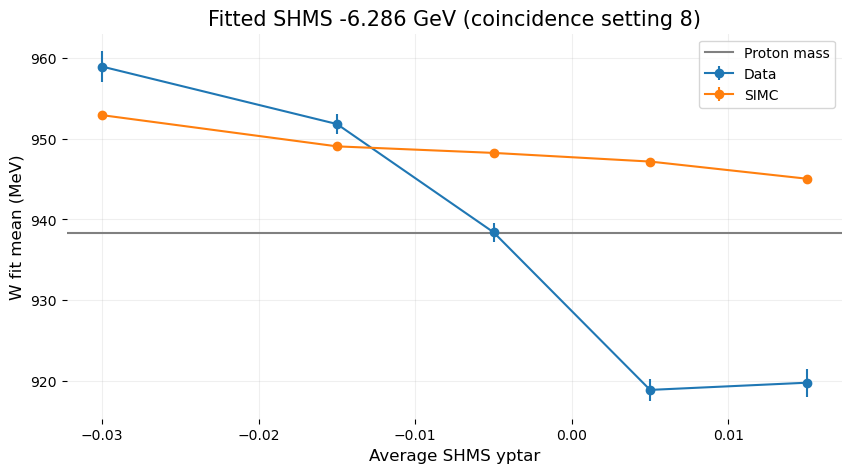

In [11]:
momentum, sn = -6.286, 8
# data = np.loadtxt(f'w_walks{momentum}shms.dat', dtype = float) # File for straightforward δ dependence
# data = np.loadtxt(f'woptar{sn}8.dat', dtype = float) # File for optics δ corrected
data = np.loadtxt(f'wyptar{sn}.dat', dtype = float) # File for yptar dependence

dataw = data[:,0]
errdw = data[:,1]
simcw = data[:,2]
errsw = data[:,3]
lod = data[:,4]
hid = data[:,5]
δmean = (lod + hid) / 2
# fig, ax  = shaxes(xlabel = 'Average δ', ylabel = 'W fit mean (MeV)', title = f'Fitted W for elastic SHMS {momentum} GeV (coincidence setting {sn})', allgone = 'y')
fig, ax  = shaxes(xlabel = 'Average SHMS yptar', ylabel = 'W fit mean (MeV)', title = f'Fitted SHMS {momentum} GeV (coincidence setting {sn})', allgone = 'y')
ax.errorbar(δmean, dataw, yerr = errdw, label = 'Data', marker = 'o', linestyle = '-')
ax.errorbar(δmean, simcw, yerr = errsw, label = 'SIMC', marker = 'o', linestyle = '-')
ax.axhline(y = Mp * 1000, color = 'gray', label = 'Proton mass')
# ax.text(0.8, 0.5, r'$δ_s→δ_s-(8⋅ϕ_s)$', transform = ax.transAxes, fontsize = 18)
ax.legend()
plt.savefig(f'plots/shmswyp{sn}{momentum}.png', dpi = 300)

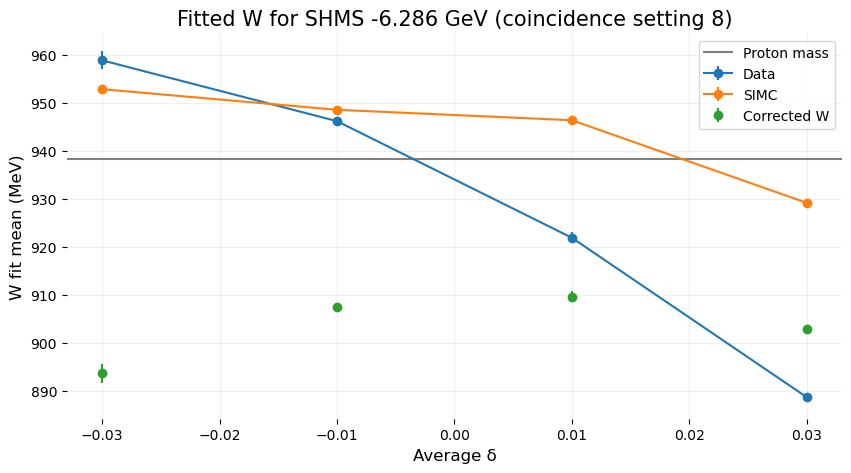

In [3]:
from scipy.optimize import curve_fit

# ------------------------------------------------------------------
# 2.  Define a modest-order polynomial for the bias        (ΔW = f(δ))
#     – 3rd order is usually flexible enough here
# ------------------------------------------------------------------
def poly3(x, a0, a1, a2, a3):
    return a0 + a1*x + a2*x**2 + a3*x**3

# ------------------------------------------------------------------
# 3.  Fit the difference from the desired flat value
#     – use proton mass (938.272 MeV) or any constant of your choice
# ------------------------------------------------------------------
W_ref    = np.mean(dataw[-2:])               # target flat value  (MeV)
ΔW_meas  = dataw - W_ref        # bias that we want to cancel

# Extend by repeating the endpoint values
δext = np.concatenate([[δmean[0] - 1], δmean, [δmean[-1] + 1]])
ΔW_ext = np.concatenate([[ΔW_meas[0]], ΔW_meas, [ΔW_meas[-1]]])
errext = np.concatenate([[errdw[0]*1.3], errdw, [errdw[-1]*1.3]])

popt, pcov = curve_fit(poly3, δext, ΔW_ext, sigma = errext, absolute_sigma = True)
# print(popt)

# ------------------------------------------------------------------
# 4.  Build the correction function and apply it
# ------------------------------------------------------------------
def w_fit(d):
    """Return the W-bias (MeV) to subtract at a given δ."""
    return poly3(d, *popt)

# corrected W values (should now be ~ W_ref for all δ)
W_corr = dataw - w_fit(δmean)

# ------------------------------------------------------------------
# 5.  Quick visual check (no title or legend per your prefs)
# ------------------------------------------------------------------
fig, ax  = shaxes(xlabel = 'Average δ', ylabel = 'W fit mean (MeV)', title = f'Fitted W for SHMS -6.286 GeV (coincidence setting {sn})', allgone = 'y')
ax.errorbar(δmean, dataw, yerr = errdw, label = 'Data', marker = 'o')
ax.errorbar(δmean, simcw, yerr = errsw, label = 'SIMC', marker = 'o')
ax.axhline(y = Mp * 1000, color = 'gray', label = 'Proton mass')
ax.errorbar(δmean, W_corr, yerr=errdw, fmt='o', label = 'Corrected W')
ax.legend()
plt.savefig(f'plots/wcorr{sn}.png', dpi = 300)

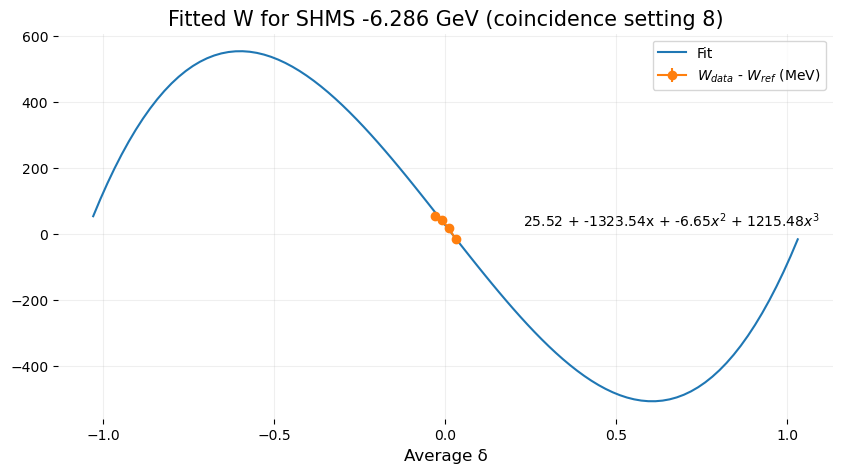

In [4]:
fig,ax = shaxes(xlabel = 'Average δ', title = f'Fitted W for SHMS -6.286 GeV (coincidence setting {sn})', allgone = 'y')
x = np.linspace(np.min(δext), np.max(δext), 100)
ax.plot(x, w_fit(x), label = 'Fit')
ax.errorbar(δmean, ΔW_meas, yerr = errsw, label = r'$W_{data}$ - $W_{ref}$ (MeV)', marker = 'o')
ax.text(0.6, 0.5, fr'{popt[0]:.2f} + {popt[1]:.2f}x + {popt[2]:.2f}$x^2$ + {popt[3]:.2f}$x^3$', transform = ax.transAxes)
ax.legend()
plt.savefig(f'plots/wfitfunc{sn}.png', dpi = 300)